In [3]:
import glob
import os
import collections
import numpy as np
import pandas as pd
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src')
import lib.taxonomy_tools as taxonomy_tools
import lib.ppk2_tools as ppk2_tools
import lib.common as common
common.set_environment_variable()
plt.rcParams["font.size"] = 12.5
plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.figsize"] = [4,4]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '7'),
  Text(0, 1.5, '6'),
  Text(0, 2.5, '5'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '3'),
  Text(0, 5.5, '2'),
  Text(0, 6.5, '1'),
  Text(0, 7.5, '0')])

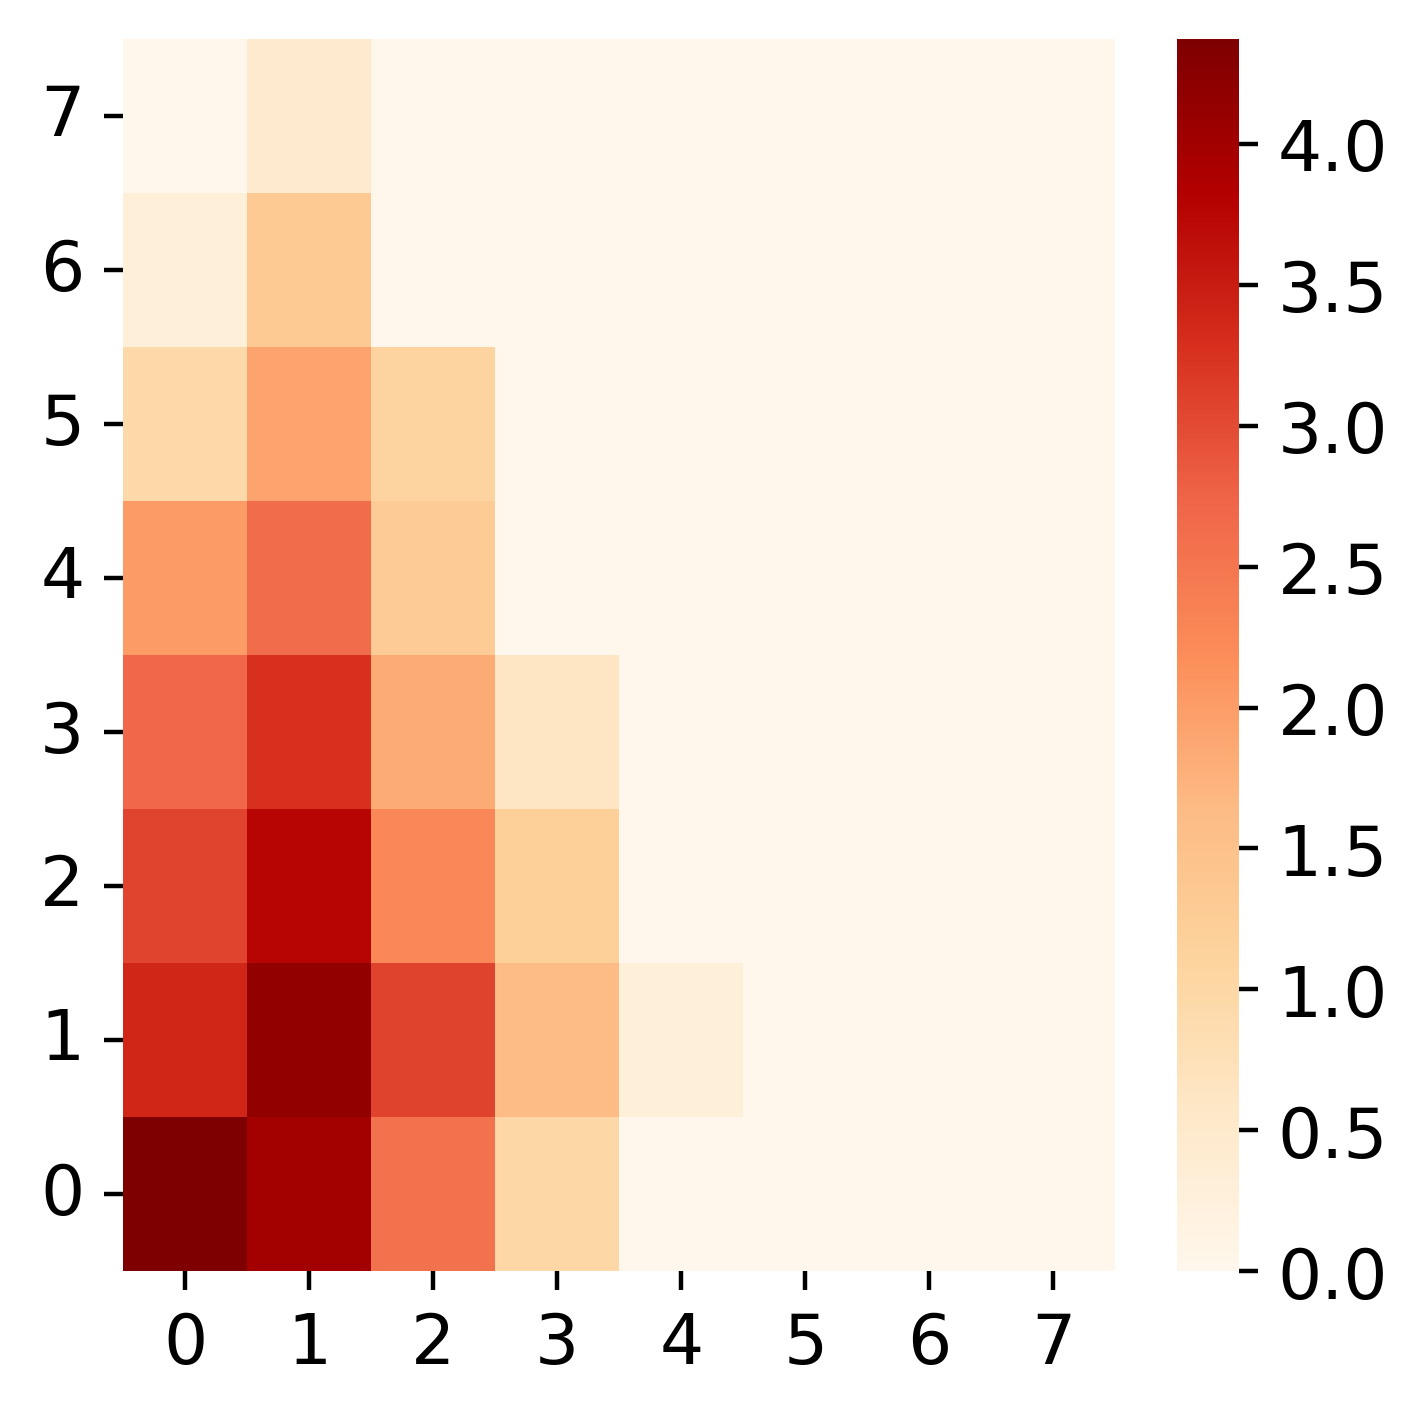

In [4]:
#fig3a
ppk2_table = pd.read_table(os.environ["Describe"])
ppk1_table = pd.read_table('../data/ppk1_bacteria_table_4domain.tsv')
hash_list = []
org_accession_list = taxonomy_tools.create_bac_gtdb_accession_list()

for org_accession in org_accession_list:
    if org_accession not in ppk2_table['org_accession'].values:
        ppk2_number = 0
    else:
        ppk2_number = ppk2_table[ppk2_table['org_accession'] == org_accession].shape[0]
    if org_accession not in ppk1_table['org_accession'].values:
        ppk1_number = 0
    else:
        ppk1_number = ppk1_table[ppk1_table['org_accession'] == org_accession].shape[0]
    hash_list.append({'org_accession':org_accession,'PPK2 counts':ppk2_number,'PPK1 counts':ppk1_number})
df_ppk_number = pd.DataFrame(hash_list)
df_ppk_number = df_ppk_number.set_index('org_accession')

df_PPK1_PPK2_pair_count = df_ppk_number.value_counts(ascending = False).reset_index(name='count')
df_PPK1_PPK2_pair_count_pivot = pd.pivot_table(data = df_PPK1_PPK2_pair_count,values='count',columns = 'PPK1 counts',index='PPK2 counts',aggfunc=np.log10).fillna(0)
df_PPK1_PPK2_pair_count_pivot.loc[:,[5,6,7]] = 0
df_PPK1_PPK2_pair_count_pivot_s = df_PPK1_PPK2_pair_count_pivot.sort_index(axis=0,ascending=False)

plt.figure (figsize= (4,4))
sns.heatmap(df_PPK1_PPK2_pair_count_pivot_s,cmap='OrRd')
plt.rcParams["font.size"] = 12
plt.xlabel("")
plt.ylabel("")
plt.yticks(rotation=0)
        


/tmp/ipykernel_548247/4184997824.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_ppk2_yes_ppk1_table = pd.concat([one_ppk2_yes_ppk1_table,df_tmp])
/tmp/ipykernel_548247/4184997824.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_ppk2_no_ppk1_table = pd.concat([one_ppk2_no_ppk1_table,df_tmp])


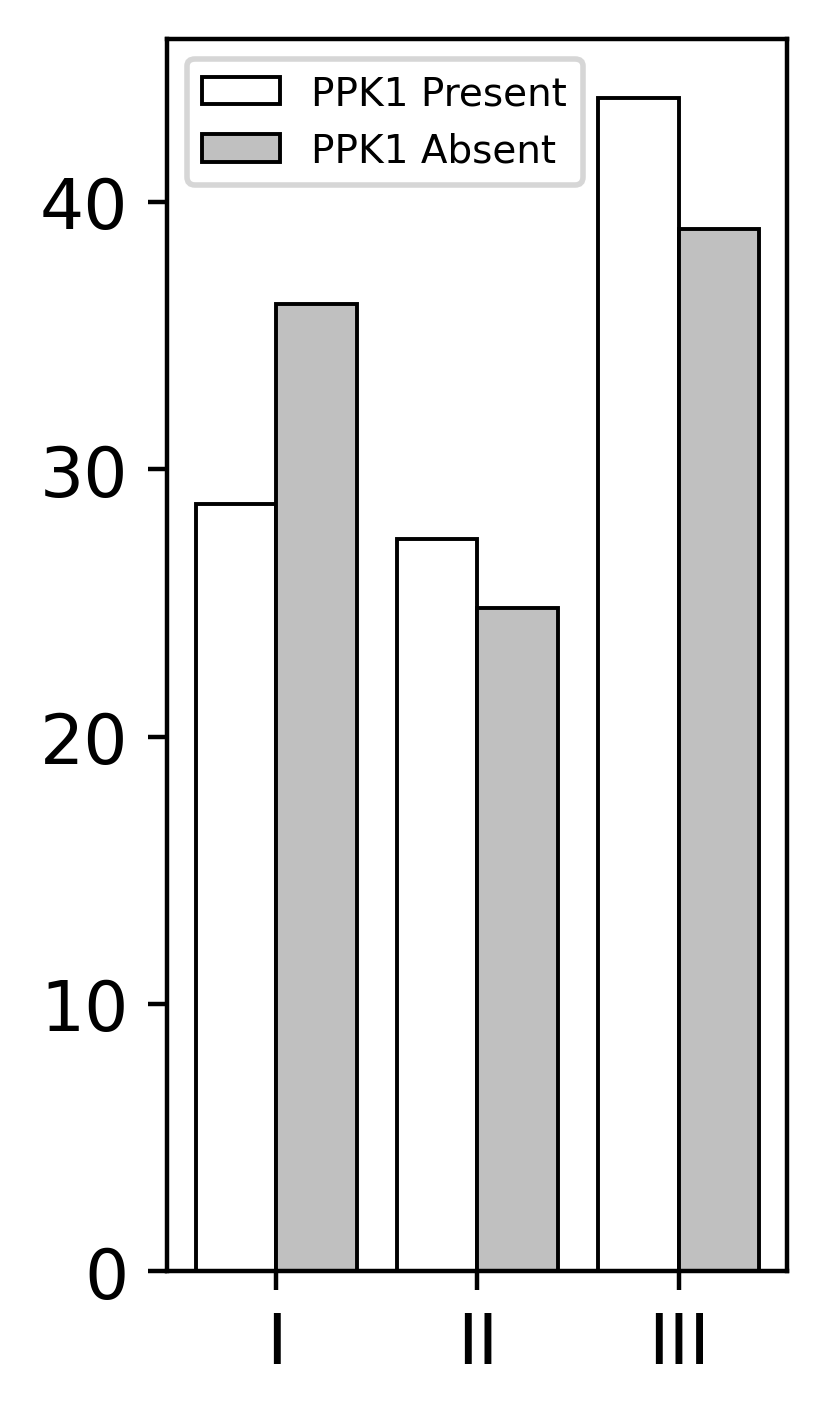

In [2]:
#fig3b
df_taxonomy = taxonomy_tools.create_taxonomy_df()
gtdb_org_accession_set = set(taxonomy_tools.create_bac_gtdb_accession_list())
taxonomy_rep_list = []
for idx, row in df_taxonomy.iterrows():
    taxonomy_rep_dict = {}
    if idx in gtdb_org_accession_set:
        taxonomy_rep_dict['accession'] = idx
        taxonomy_rep_dict['taxonomy'] = row['taxonomy']
        taxonomy_rep_list.append(taxonomy_rep_dict)
df_taxonomy_rep = pd.DataFrame(taxonomy_rep_list)
genus_list = list(set([taxonomy.split(';')[-2] for taxonomy in df_taxonomy_rep.taxonomy]))
family_list = list(set([taxonomy.split(';')[-3] for taxonomy in df_taxonomy_rep.taxonomy])) 

ppk2_table = ppk2_tools.create_ppk2_describe_df()
ppk1_table = pd.read_table('../data/ppk1_bacteria_table_4domain.tsv')
ppk1_table.index = ppk1_table['gene_accession']; ppk1_table = ppk1_table.drop('gene_accession',axis = 1)
ppk1_exist_org = set(ppk1_table.org_accession)

one_ppk2_yes_ppk1_table = pd.DataFrame(columns = ppk2_table.columns)
for org_accession in list(set(ppk2_table.org_accession)):
    df_tmp = ppk2_table.query(f"org_accession == '{org_accession}'")
    if (len(df_tmp) == 1) and (org_accession in ppk1_exist_org):
        one_ppk2_yes_ppk1_table = pd.concat([one_ppk2_yes_ppk1_table,df_tmp])
one_ppk2_yes_ppk1_dict = dict(collections.Counter(list(one_ppk2_yes_ppk1_table.ppk2_class)))

one_ppk2_no_ppk1_table = pd.DataFrame(columns = ppk2_table.columns)
for org_accession in list(set(ppk2_table.org_accession)):
    df_tmp = ppk2_table.query(f"org_accession == '{org_accession}'")
    if (len(df_tmp) == 1) and (org_accession not in ppk1_exist_org):
        one_ppk2_no_ppk1_table = pd.concat([one_ppk2_no_ppk1_table,df_tmp])
one_ppk2_no_ppk1_dict = dict(collections.Counter(list(one_ppk2_no_ppk1_table.ppk2_class)))


dataset = pd.DataFrame([one_ppk2_yes_ppk1_dict,one_ppk2_no_ppk1_dict]).T
dataset = dataset.rename(columns={0: 'PPK1 Present',1: 'PPK1 Absent'})
plot_dataset = pd.DataFrame(index = dataset.index)
for col in dataset.columns:
    plot_dataset[col] = round(100 * dataset[col] / dataset[col].sum(), 1)
plot_dataset = plot_dataset.sort_index()
plot_dataset = plot_dataset.T 

plt.rcParams["font.size"] = 12.5

fig, ax = plt.subplots(figsize=(2, 4))
color_list = ['b','g','r']
bar_width = 0.4
x = np.array([1,2,3])
x_yes = x - bar_width/2
x_no = x + bar_width/2
y_yes = np.array(plot_dataset.loc['PPK1 Present',:])
y_no = np.array(plot_dataset.loc['PPK1 Absent',:])
ax.bar(x_yes,y_yes,label='PPK1 Present',width=bar_width,color="white",edgecolor="k",linewidth=0.7 )
ax.bar(x_no,y_no,label='PPK1 Absent',width=bar_width,color="silver",edgecolor="k",linewidth=0.7 )
ax.set_xticks(x,['I','II','III'])
ax.legend(plot_dataset.index, loc='upper left',prop={'size': 7})
plt.show()


/tmp/ipykernel_390785/2213855175.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_ppk2_table = pd.concat([one_ppk2_table,df_tmp])
/tmp/ipykernel_390785/2213855175.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_ppk2_present_ppk1_table = pd.concat([one_ppk2_present_ppk1_table,df_tmp])
/tmp/ipykernel_390785/2213855175.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or a

medium -1.5678383229299473
medium -0.7832592464401411
medium 0.0
medium 0.0
medium 0.2735650733259635
medium 0.5081469036703253
medium 0.7198920808072649
medium 0.8126421661728559
medium 1.1481962436871544
medium 1.2788593729954763
medium 1.8556100906648252
medium 2.1996723448363644
medium 3.928765095231281


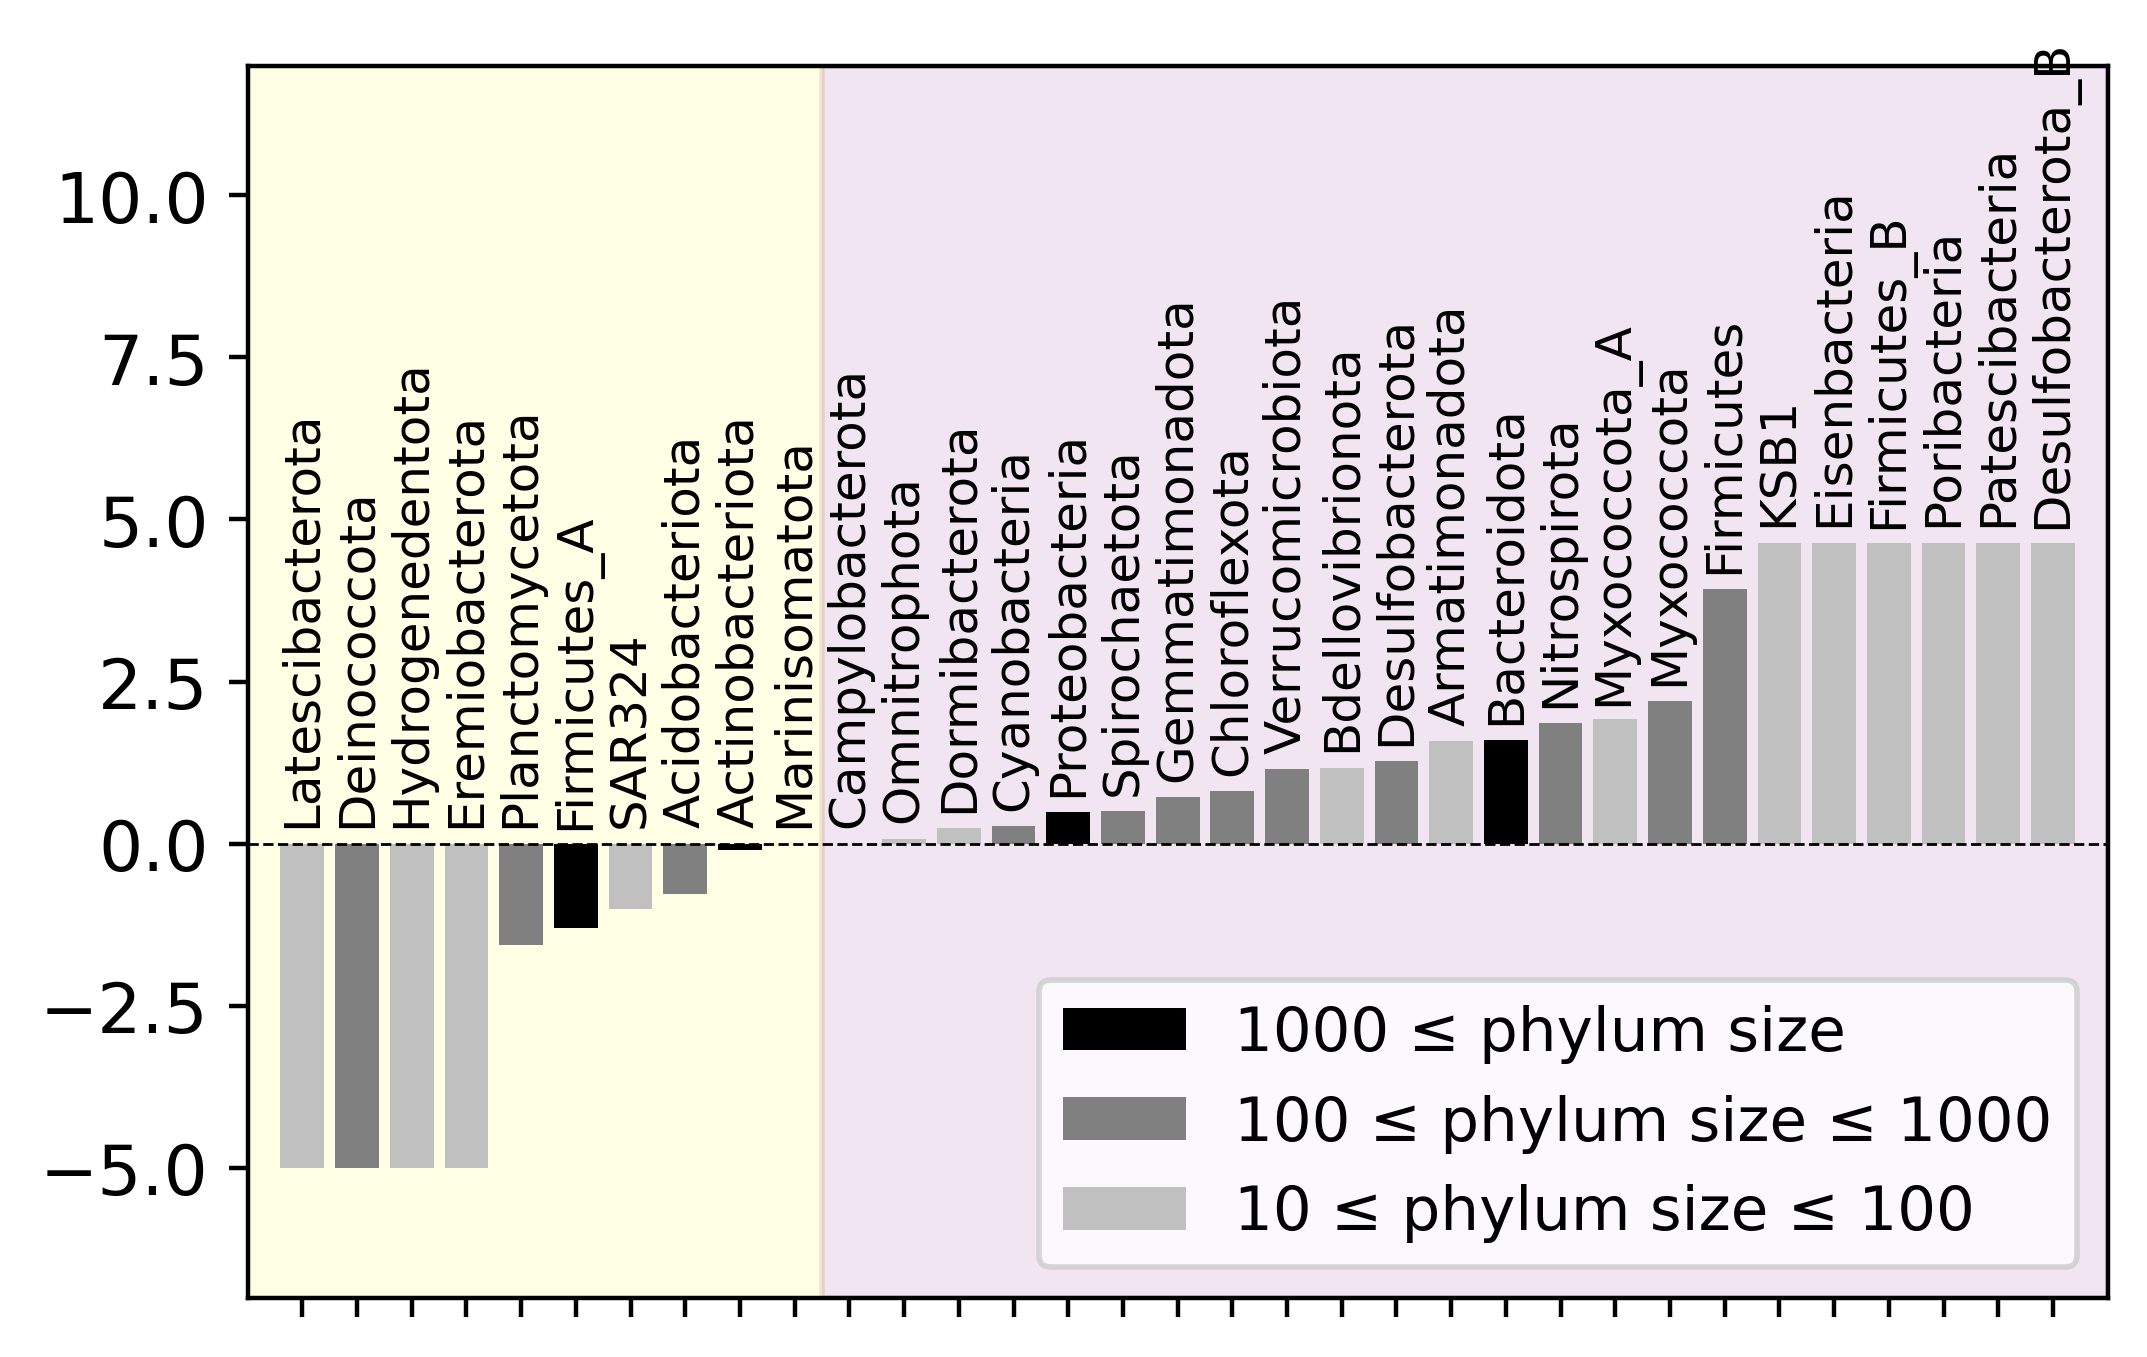

In [ ]:
df_taxonomy = taxonomy_tools.create_taxonomy_df()
gtdb_org_accession_set = set(taxonomy_tools.create_bac_gtdb_accession_list())
taxonomy_rep_list = []
for idx, row in df_taxonomy.iterrows():
    taxonomy_rep_dict = {}
    if idx in gtdb_org_accession_set:
        taxonomy_rep_dict['accession'] = idx
        taxonomy_rep_dict['taxonomy'] = row['taxonomy']
        taxonomy_rep_list.append(taxonomy_rep_dict)
df_taxonomy_rep = pd.DataFrame(taxonomy_rep_list)
genus_list = list(set([taxonomy.split(';')[-2] for taxonomy in df_taxonomy_rep.taxonomy]))
family_list = list(set([taxonomy.split(';')[-3] for taxonomy in df_taxonomy_rep.taxonomy])) 

ppk2_table = ppk2_tools.create_ppk2_describe_df()
ppk1_table = pd.read_table('../data/ppk1_bacteria_table_4domain.tsv')
ppk1_table.index = ppk1_table['gene_accession']; ppk1_table = ppk1_table.drop('gene_accession',axis = 1)

#genus
ppk2_table['genus'] = [taxonomy.split(';')[-2] for taxonomy in ppk2_table['taxonomy']]
ppk1_table['genus'] = [taxonomy.split(';')[-2] for taxonomy in ppk1_table['taxonomy']]
df_taxonomy_rep['genus'] = [taxonomy.split(';')[-2] for taxonomy in df_taxonomy_rep['taxonomy']] 
#family
ppk2_table['family'] = [taxonomy.split(';')[-3] for taxonomy in ppk2_table['taxonomy']]
ppk1_table['family'] = [taxonomy.split(';')[-3] for taxonomy in ppk1_table['taxonomy']]
df_taxonomy_rep['family'] = [taxonomy.split(';')[-3] for taxonomy in df_taxonomy_rep['taxonomy']] 
#order
ppk2_table['order'] = [taxonomy.split(';')[-4] for taxonomy in ppk2_table['taxonomy']]
ppk1_table['order'] = [taxonomy.split(';')[-4] for taxonomy in ppk1_table['taxonomy']]
df_taxonomy_rep['order'] = [taxonomy.split(';')[-4] for taxonomy in df_taxonomy_rep['taxonomy']] 
#class
ppk2_table['class'] = [taxonomy.split(';')[-5] for taxonomy in ppk2_table['taxonomy']]
ppk1_table['class'] = [taxonomy.split(';')[-5] for taxonomy in ppk1_table['taxonomy']]
df_taxonomy_rep['class'] = [taxonomy.split(';')[-5] for taxonomy in df_taxonomy_rep['taxonomy']] 
#phylum
ppk2_table['phylum'] = [taxonomy.split(';')[-6] for taxonomy in ppk2_table['taxonomy']]
ppk1_table['phylum'] = [taxonomy.split(';')[-6] for taxonomy in ppk1_table['taxonomy']]
df_taxonomy_rep['phylum'] = [taxonomy.split(';')[-6] for taxonomy in df_taxonomy_rep['taxonomy']] 
ppk1_exist_org = set(ppk1_table.org_accession)

one_ppk2_table = pd.DataFrame(columns = ppk2_table.columns)
for org_accession in list(set(ppk2_table.org_accession)):
    df_tmp = ppk2_table.query(f"org_accession == '{org_accession}'")
    if (len(df_tmp) == 1):
        one_ppk2_table = pd.concat([one_ppk2_table,df_tmp])

one_ppk2_present_ppk1_table = pd.DataFrame(columns = ppk2_table.columns)
for org_accession in list(set(ppk2_table.org_accession)):
    df_tmp = ppk2_table.query(f"org_accession == '{org_accession}'")
    if (len(df_tmp) == 1) and (org_accession in ppk1_exist_org):
        one_ppk2_present_ppk1_table = pd.concat([one_ppk2_present_ppk1_table,df_tmp])

one_ppk2_absent_ppk1_table = pd.DataFrame(columns = ppk2_table.columns)
for org_accession in list(set(ppk2_table.org_accession)):
    df_tmp = ppk2_table.query(f"org_accession == '{org_accession}'")
    if (len(df_tmp) == 1) and (org_accession not in ppk1_exist_org):
        one_ppk2_absent_ppk1_table = pd.concat([one_ppk2_absent_ppk1_table,df_tmp])

one_ppk2_c1_table = one_ppk2_table.query('ppk2_class == 1')
one_ppk2_c1_absent_ppk1_table  = one_ppk2_absent_ppk1_table .query('ppk2_class == 1')
one_ppk2_c1_present_ppk1_table  = one_ppk2_present_ppk1_table .query('ppk2_class == 1')


plt.rcParams["figure.figsize"] = [6,4]

one_ppk2_c1_absent_ppk1_set = set(one_ppk2_c1_absent_ppk1_table.phylum)
one_ppk2_c1_present_ppk1_set = set(one_ppk2_c1_present_ppk1_table.phylum)
present_absent_ratio_by_phylum = {}
species_num_in_phylum_dict = {}
for phylum in list(set(one_ppk2_c1_table.phylum)):
    one_ppk2_c1_absent_ppk1_species_number = 0
    one_ppk2_c1_present_ppk1_species_number = 0
    one_ppk2_c1_absent_ppk1_species_fraction = 0
    one_ppk2_c1_present_ppk1_species_fraction = 0
    if len(one_ppk2_table.query(f"phylum == '{phylum}'")) < 10:
        continue
    species_num_in_phylum_dict[phylum] = len(ppk2_table.query(f"phylum == '{phylum}'")) 
    if phylum in one_ppk2_c1_absent_ppk1_set:
        one_ppk2_c1_absent_ppk1_species = one_ppk2_c1_absent_ppk1_table.query(f"phylum == '{phylum}'")
        one_ppk2_c1_absent_ppk1_species_number = len(one_ppk2_c1_absent_ppk1_species)
        one_ppk2_absent_ppk1_species_number = len(one_ppk2_absent_ppk1_table.query(f"phylum == '{phylum}'"))
        one_ppk2_c1_absent_ppk1_species_fraction = one_ppk2_c1_absent_ppk1_species_number/one_ppk2_absent_ppk1_species_number
    if phylum in one_ppk2_c1_present_ppk1_set:
        one_ppk2_c1_present_ppk1_species = one_ppk2_c1_present_ppk1_table.query(f"phylum == '{phylum}'")
        one_ppk2_c1_present_ppk1_species_number = len(one_ppk2_c1_present_ppk1_species)
        one_ppk2_present_ppk1_species_number = len(one_ppk2_present_ppk1_table.query(f"phylum == '{phylum}'"))
        one_ppk2_c1_present_ppk1_species_fraction = one_ppk2_c1_present_ppk1_species_number/one_ppk2_present_ppk1_species_number
    if one_ppk2_c1_absent_ppk1_species_fraction == 0 and one_ppk2_c1_present_ppk1_species_fraction == 0: 
        continue
    elif one_ppk2_c1_absent_ppk1_species_fraction == 0:
        present_absent_ratio_by_phylum[phylum] = -5
    elif one_ppk2_c1_present_ppk1_species_fraction == 0:
        present_absent_ratio_by_phylum[phylum] = 25
    else:
        present_absent_ratio_by_phylum[phylum] = one_ppk2_c1_absent_ppk1_species_fraction/one_ppk2_c1_present_ppk1_species_fraction
present_absent_ratio_by_phylum_list = sorted(present_absent_ratio_by_phylum.items(), key=lambda x:x[1])

#figure
fig,ax = plt.subplots(1,1)
large_phylum_idx_list = []; medium_phylum_idx_list = []; small_phylum_idx_list = []; very_small_phylum_idx_list = []
large_phylum_value_list = []; medium_phylum_value_list = []; small_phylum_value_list = []; very_small_phylum_value_list = []

for idx,phylum_tup in enumerate(present_absent_ratio_by_phylum_list):
    if species_num_in_phylum_dict[phylum_tup[0]] >= 1000:
        large_phylum_idx_list.append(idx+1)
        if phylum_tup[1] > 0:
            large_phylum_value_list.append(math.log2(phylum_tup[1]))
        else:
            large_phylum_value_list.append(phylum_tup[1])

    elif species_num_in_phylum_dict[phylum_tup[0]] >= 100:
        medium_phylum_idx_list.append(idx+1)
        if phylum_tup[1] > 0:
            medium_phylum_value_list.append(math.log2(phylum_tup[1]))
            print(f"medium {math.log2(phylum_tup[1])}")
        else:
            medium_phylum_value_list.append(phylum_tup[1])
    elif species_num_in_phylum_dict[phylum_tup[0]] >= 10:
        small_phylum_idx_list.append(idx+1)
        if phylum_tup[1] > 0:
            small_phylum_value_list.append(math.log2(phylum_tup[1]))
        else:
            small_phylum_value_list.append(phylum_tup[1])
    else:
        very_small_phylum_idx_list.append(idx+1)
        if phylum_tup[1] > 0:
            very_small_phylum_value_list.append(math.log2(phylum_tup[1]))
        else:
            very_small_phylum_value_list.append(phylum_tup[1])
    

plt.axvspan(0, 10.5, color='yellow', alpha=0.1)
plt.axvspan(10.5, len(present_absent_ratio_by_phylum_list)+1,color='purple', alpha=0.1)
ax.bar(large_phylum_idx_list,large_phylum_value_list,color='k',label='1000 ≤ phylum size')
ax.bar(medium_phylum_idx_list,medium_phylum_value_list,color='grey',label='100 ≤ phylum size ≤ 1000')
ax.bar(small_phylum_idx_list,small_phylum_value_list,color='silver',label='10 ≤ phylum size ≤ 100')
ax.set_xlim([0,len(present_absent_ratio_by_phylum_list)+1])
ax.set_ylim([-7,12])
ax.axhline(y=0,color='k',linestyle='--',linewidth=0.5)

phylum_idx = [i+1 for i in range(len(present_absent_ratio_by_phylum_list))]
plt.xticks(phylum_idx,['' for i in range(len(present_absent_ratio_by_phylum_list))])
plt.legend(loc = 'lower right',prop={'size': 11})
for i in range(1,len(present_absent_ratio_by_phylum_list)+1):
    if present_absent_ratio_by_phylum_list[i-1][1] > 0:
        text_height = math.log2(present_absent_ratio_by_phylum_list[i-1][1])
    else:
        text_height = 0
    if text_height > 0:
        text_height += 0.4
    else:
        text_height = 0.4
    ax.text(i-0.45,text_height,re.sub('p__','',present_absent_ratio_by_phylum_list[i-1][0]),rotation = 90,fontsize=9)



